<a href="https://colab.research.google.com/github/changhorang/SSAC_study/blob/main/DL/07_CNN_MNIST%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EC%A0%80%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network 구현

- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교 해본다.

##### 학습결과 시각화 함수 정의

In [1]:
!nvidia-smi

Mon Dec  6 06:22:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import matplotlib.pyplot as plt

# loss 그래프
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [3]:
# accuracy 그래프
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [4]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [5]:
np.random.seed(0)
tf.random.set_seed(0)

##### data loading

In [6]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape
# (60000, 28, 28) - (개수, height, width) => channel 축이 없으므로 늘릴 것!

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

##### 하이퍼파라미터, 변수 설정

In [7]:
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100

N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

##### 전처리, Dataset 생성
- X: 0 ~ 1 scaling
    - gray scale 일 경우 channel 축을 늘려줘야 한다. (h, w, 1)
- Y: onehot encoding

In [8]:
# X: 0 ~ 1 scaling
X_train_tmp = (train_image/255.0).astype(np.float32)
X_test_tmp = (test_image/255.0).astype(np.float32)

# channel 축을 추가
# ...: 원래 shape, np.newaxis는 크기가 1인 axis 추가
X_train = X_train_tmp[..., np.newaxis] # (60000, 28, 28, 1)
X_test = X_test_tmp[..., np.newaxis]
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [9]:
# y: onehot-encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

###### Dataset 생성

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

## Model(Network) 정의
- Feature Extraction(backbone):Convolution Layer
    - block: Convolution + MaxPooling Layer
    - size(height, width) 는 줄이고 channel은 늘리는 방향으로 Layer들을 쌓는다.
    - convolution
        - size: 3 X 3
        - strides: 1
    - max pooling
        - size: 2 X 2
        - strides: 2
- 분류기
    - Dense Layer 사용        
    - Flatten을 먼저 해야 한다. (Conv의 output-feature map- 3차원 배열)


In [11]:
def create_mnist_model():
    model = keras.Sequential()

    model.add(layers.InputLayer((28, 28, 1))) # Conv2D의 input은 3차원 (h, w, c)

    model.add(layers.Conv2D(filters=32,         # filter의 개수
                            kernel_size=(3,3),  # filter size (h, w)
                            padding='same',     # input과 output(feature map) size가 동일하도록 zero-padding 추가 [default:'valid']
                            strides=(1,1),      # conv 연산시 이동 보폭 (좌우, 상하) [default=1]
                            activation='relu'   # conv연산 결과를 넣어줄 활성함수
                            ))
    
    model.add(layers.MaxPool2D(pool_size=(2,2), # (2, 2) 영역에서 가장 큰 값 하나를 추출 [default: (2, 2)]
                               strides=(2,2),   # 이동 보폭. [default:none] / pool_size의 설정과 동일한 크기
                               padding='same')) # [default: valid] / 나머지 짜투리 영역은 버림
                                                # same - 짜투리 영역에서도 가장 큰 값을 추출

    model.add(layers.Conv2D(filters=64,         # 필터 개수는 늘리기
                            kernel_size=3,      # (h, w) - h, w 크기가 같은 경우, 값 하나만 지정
                            padding='same',
                            activation='relu'
                            ))
    
    model.add(layers.MaxPool2D(padding='same')) # pool_size/stride는 default((2, 2), None) 사용
                                                # padding - default : valid

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    # 출력 feature map 하나의 shape => 3차원 (h, w, c) => 2차원
    model.add(layers.Flatten())

    model.add(layers.Dense(units=256, activation='relu'))

    # soft max를 통해 각 라벨에 해당하는 확률 구함
    model.add(layers.Dense(units=10, activation='softmax'))

    return model

##### 컴파일

In [12]:
model = create_mnist_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [15]:
# conv 파라미터 개수
# (filter_width*filter_height)*input_channel*filter개수 +  filter개수(bias)
# 1번 conv
print(3*3*1*32+32)
# 2번 conv 파라미터
print(3*3*32*64+64)

320
18496


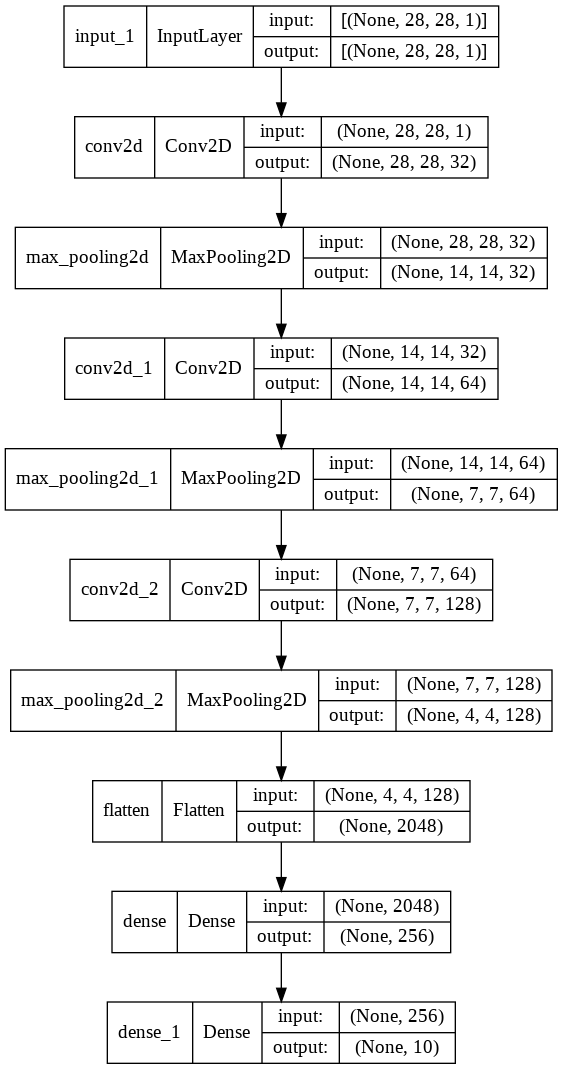

In [16]:
keras.utils.plot_model(model, show_shapes=True)

##### 학습

In [17]:
hist = model.fit(train_dataset, 
                 epochs=N_EPOCHS, 
                 validation_data=test_dataset)

Epoch 1/20
600/600 [==============================] - 19s 16ms/step - loss: 0.1617 - accuracy: 0.9500 - val_loss: 0.0425 - val_accuracy: 0.9850
Epoch 2/20
600/600 [==============================] - 10s 16ms/step - loss: 0.0449 - accuracy: 0.9860 - val_loss: 0.0467 - val_accuracy: 0.9851
Epoch 3/20
600/600 [==============================] - 10s 16ms/step - loss: 0.0305 - accuracy: 0.9906 - val_loss: 0.0293 - val_accuracy: 0.9903
Epoch 4/20
600/600 [==============================] - 10s 16ms/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 0.0236 - val_accuracy: 0.9922
Epoch 5/20
600/600 [==============================] - 10s 17ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 6/20
600/600 [==============================] - 10s 16ms/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.0194 - val_accuracy: 0.9938
Epoch 7/20
600/600 [==============================] - 10s 16ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.0261 - val_accuracy:

##### 결과시각화

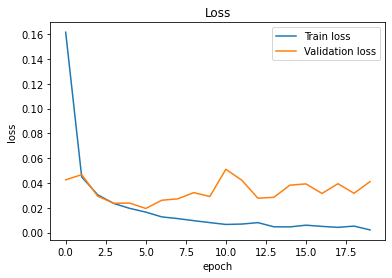

In [18]:
plot_loss(hist)

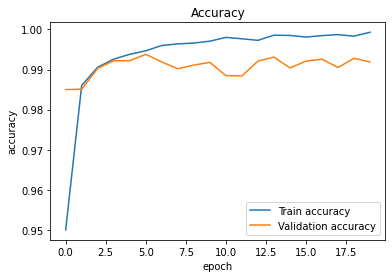

In [19]:
plot_accuracy(hist)

##### 최종검증

In [20]:
loss, acc = model.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.0411 - accuracy: 0.9919


In [21]:
print(loss, acc)

0.04111126810312271 0.9919000267982483


## prediction error가 발생한 example 확인
- test dataset으로 예측한 결과중 틀린 것들을 확인해 본다.

In [22]:
pred = model.predict(X_test)
pred.shape

(10000, 10)

In [24]:
pred[:5, :4]

array([[2.5732060e-22, 3.4400304e-17, 3.1737241e-18, 4.6382201e-18],
       [1.2618986e-13, 4.4444676e-17, 1.0000000e+00, 3.6812333e-18],
       [5.2558858e-13, 1.0000000e+00, 3.3608021e-14, 1.9844237e-17],
       [1.0000000e+00, 3.1895947e-21, 8.5965903e-18, 3.3473270e-19],
       [9.1240483e-17, 3.2243295e-11, 1.5979459e-16, 1.4594378e-16]],
      dtype=float32)

In [25]:
pred_label = np.argmax(pred, axis=-1)
pred_label.shape

(10000,)

In [26]:
# test_label(target) 와 pred_label(prediction) 간에 틀린 것의 index를 조회
idx = np.where(test_label != pred_label)[0]
idx.shape

(81,)

In [27]:
# index별 틀린 것 조회
idx[:5]

array([ 18, 151, 247, 264, 321])

##### confusion matrix 확인

In [28]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(test_label, pred_label)

array([[ 976,    0,    0,    0,    0,    0,    2,    2,    0,    0],
       [   0, 1133,    0,    1,    0,    0,    0,    1,    0,    0],
       [   1,    0, 1024,    0,    0,    0,    0,    6,    1,    0],
       [   0,    0,    1, 1004,    0,    3,    0,    1,    1,    0],
       [   0,    0,    1,    0,  973,    0,    2,    0,    1,    5],
       [   1,    0,    0,    3,    0,  887,    1,    0,    0,    0],
       [   2,    1,    0,    0,    0,    2,  952,    0,    1,    0],
       [   0,    3,    2,    0,    0,    0,    0, 1021,    0,    2],
       [   2,    0,    0,    1,    0,    2,    0,    0,  969,    0],
       [   1,    0,    0,    3,    9,    4,    0,    6,    6,  980]])

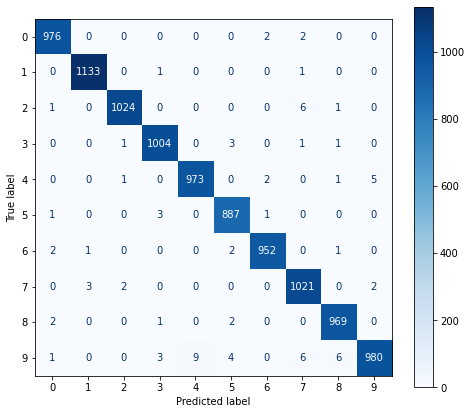

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
ax = plt.gca()

cm = confusion_matrix(test_label, pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.show()

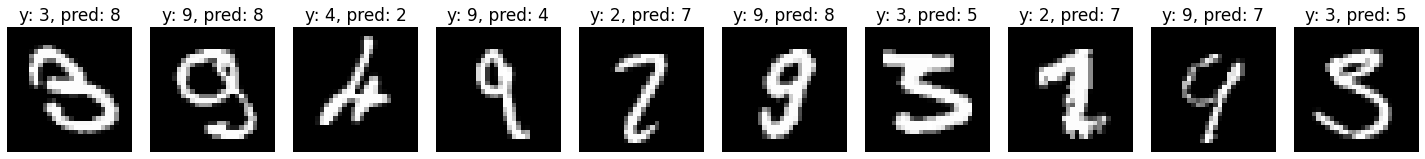

In [33]:
# 틀린 결과 중에 10개 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

for i in range(10):  
   
    error_idx = idx[i]
    
    p = pred_label[error_idx] # 추론 결과들
    y = test_label[error_idx] # targets

    plt.subplot(1, 10, i+1)
    plt.imshow(test_image[error_idx], cmap='gray')
    plt.title(f"y: {y}, pred: {p}", fontsize=17)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 학습한 모델 파일로 저장

- **무엇을 저장할 지**
    1. Train이 끝난 모델의 파라미터만 저장
    1. 모델 구조와 파라미터 모두 저장

- **저장시점**
    1. Train 완료된 모델을 저장
    1. Callback을 이용해 Train 도중 가장 성능이 좋은 시점의 모델을 저장

## 텐서플로 저장 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 타입

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장
    - `model.save_weights("저장경로")`
- 불러오기
    - `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`
        - 또는 파일 확장자를 h5로 지정한다.

### Checkpoint 으로 저장

##### 저장할 경로 생성및 저장

In [ ]:
import os

base_dir = "/content/drive/MyDrive/saved_models"
mnist_weight_dir = os.path.join(base_dir, "mnist_weight")
print(mnist_weight_dir)

if not os.path.isdir(mnist_weight_dir):
    os.mkdir(mnist_weight_dir)
    
weight_file_path = os.path.join(mnist_weight_dir, "mnist_weight.ckpt")

print(weight_file_path)

In [ ]:
model.save_weights(weight_file_path)

In [ ]:
new_model = create_mnist_model()
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [ ]:
new_model.evaluate(test_dataset)

In [ ]:
new_model.load_weights(weight_file_path)

In [ ]:
new_model.evaluate(test_dataset)

### h5 형식으로 저장

In [ ]:
weight_h5_dir = os.path.join(base_dir, "mnist_weight_h5")
if not os.path.isdir(weight_h5_dir):
    os.makedirs(weight_h5_dir, exist_ok=True)
weight_h5_path = os.path.join(weight_h5_dir, "mnist_weight.h5")

In [ ]:
model.save_weights(weight_h5_path, save_format='h5')

In [ ]:
new_model = create_mnist_model()
new_model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
new_model.evaluate(test_dataset)

In [ ]:
new_model.load_weights(weight_h5_path)

In [ ]:
new_model.evaluate(test_dataset)

## 전체 모델 저장하고 불러오기
- https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ko
- 저장
    - `model.save('저장할디렉토리')`
- 불러오기
    - `tf.keras.models.load_model('저장된디렉토리')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 
        - 또는 파일의 확장자를 h5로 지정한다.

###  Saved Model 형식으로 모델 저장
- 경로(디렉토리) 만 지정한다.

In [ ]:
mnist_model_dir = os.path.join(base_dir, 'mnist_model')
print(mnist_model_dir, type(mnist_model_dir))
if not os.path.isdir(mnist_model_dir):
    os.mkdir(mnist_model_dir) 

In [ ]:
model.save(mnist_model_dir)

In [ ]:
new_model2 = keras.models.load_model(mnist_model_dir)

In [ ]:
new_model2.evaluate(test_dataset)

### H5 형식으로 모델 저장

In [ ]:
model_h5_dir = os.path.join(base_dir, 'mnist_model_h5')

if not os.path.join(model_h5_dir):
    os.makedirs(model_h5_dir, exist_ok=True)

model_h5_path = os.path.join(model_h5_dir, "mnist_model.h5")

In [ ]:
model.save(model_h5_path, save_format='h5')

In [ ]:
new_model3 = keras.models.load_model(model_h5_path)

new_model3.summary()

In [ ]:
new_model3.evaluate(test_dataset)

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- ### ModelCheckpoint
    - 각 epoch 마다 학습한 모델과 weight(또는 weight만)를 저장한다. 
    - 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight만 저장할 수 있다.
    - 주요 파라미터
        - `save_weights_only=True`: True: 파라미터(weight)만 저장한다. False: 모델구조와 파라미터 모두 저장한다.
        - `save_best_only=True`: 학습중 성능이 개선될 때만 저장한다. (False:기본값 - 모든 에폭마다 저장한다.)
- ### EarlyStopping
    - Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈추는 callback
    - 주요 파라미터
        - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
        - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 

- **callback 객체들을 리스트로 묶은 뒤 fit()의 callbacks 매개변수에 전달한다.**

In [ ]:
model2 = create_mnist_model()
model2.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [ ]:
model2.evaluate(test_dataset)

In [ ]:
checkpoint_save_dir = os.path.join(base_dir, 'mnist_callback')
if not os.path.isdir(checkpoint_save_dir):
    os.mkdir(checkpoint_save_dir)

checkpoint_save_file = os.path.join(checkpoint_save_dir, 'mnist_ckpt')

In [ ]:
mc_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_file, 
                          save_best_only=True, 
                          monitor='val_loss',  
                          verbose=1)

In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5
                                            verbose=1)

In [ ]:
hist = model2.fit(train_dataset, epochs=5, validation_data=test_dataset,
                  callbacks=[mc_callback, es_callback])

In [ ]:
new_model3 = keras.models.load_model(checkpoint_save_file)

In [ ]:
new_model3.evaluate(test_dataset)